In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import math
from collections import Counter
import matplotlib.pyplot as plt
import statistics

# Read and Combine Data

In [3]:
languages = ['chinese', 'german', 'french', 'thai', 'japanese', 'spanish', 'italian', 'korean', 'russian', 'portuguese']
languageColumns = ['Author', 'Date', 'Rating', 'AuthorKarma']

In [4]:
dfs = []
for language in languages:
    d = pd.read_csv('data/' + language + '.csv')
    d['originalLanguage'] = language
    
    for column in languageColumns:
        d['original' + column] = d[language + column]
        d = d.drop([language + column], axis=1)
    
    dfs.append(d)

data = pd.concat(dfs, axis=0, ignore_index=True)
    

In [5]:
len(data)

219

In [6]:
# add the texts
data['originalText'] = data.apply(lambda x: open('data/' + x['originalLanguage'] + "Originals/" + x['scpId'] + '.txt').read(), axis=1)
data['englishText'] = data.apply(lambda x: open('data/englishFrom' + x['originalLanguage'].capitalize() + "/" + x['scpId'] + '.txt').read(), axis=1)

In [7]:
data.head()

,scpId,href,name,englishRating,englishDate,englishAuthor,englishAuthorKarma,originalLanguage,originalAuthor,originalDate,originalRating,originalAuthorKarma,originalText,englishText
0,SCP-CN-1000,/scp-cn-1000,2300,"+12,+12,+12,+12",29 Mar 2019 00:01,Cynthia7979,very high,chinese,Infas12,30 Oct 2018 15:25,"+574,+574,+574,+574",very high,\n \n\n\n\n\n\n\n评分: +5...,\n \n\n\n\n\n\n\nrating...
1,SCP-CN-994,/scp-cn-994,I See You,+26,18 Mar 2018 07:50,W Asriel,guru,chinese,AndyBlocker,11 Mar 2018 01:28,+858,high,\n \n\n评分: +858+–x\n\n\...,\n \n\nrating: +26+–x\n...
2,SCP-CN-918,/scp-cn-918,NaN,+4,04 May 2018 14:48,Idokoe,high,chinese,qjfoidnh,29 Apr 2018 15:46,+49,very high,\n \n\n评分: +49+–x\n\n\n...,\n \n\nrating: +4+–x\n\...
3,SCP-CN-844,/scp-cn-844,The Seed of Lovesickness,0,20 Jul 2018 07:09,Cynthia7979,very high,chinese,Cynthia7979,02 Jun 2018 14:48,+19,very high,\n \n\n评分: +19+–x\n项目编号...,\n \n\nrating: 0+–x\nIt...
4,SCP-CN-767,/scp-cn-767,Chart Syndrome,+11,10 Aug 2018 14:28,KirkeStein,high,chinese,breaddddd,15 Feb 2018 09:08,+118,very high,\n \n\n评分: +118+–x\n\n\...,\n \n\nrating: +11+–x\n...


# Clean the Data

In [8]:
cleaned = data.drop(['name', 'href'], axis=1)

In [9]:
# fix up ratings
ratingColumns = ['originalRating', 'englishRating']
for column in ratingColumns:
    cleaned[column] = cleaned[column].map(lambda x: float(str(x).split(',')[0]))
    mask = cleaned[column].apply(lambda x: not math.isnan(x))
    cleaned = cleaned[mask]

In [10]:
# tokenize the text
#charLanguages = ['chinese', 'japanese', 'korean', 'thai']
#charLanguages = []
charLanguages = ['chinese', 'japanese', 'thai']
cleaned['englishText'] = cleaned['englishText'].apply(lambda x: x.split())
cleaned['originalText'] = cleaned.apply(lambda x: list(x['originalText']) if x['originalLanguage'] in charLanguages else x['originalText'].split(), axis=1)

In [11]:
# remove whitespace
cleaned['originalText'] = cleaned['originalText'].apply(lambda y: list(filter(lambda x: not x.isspace(), y)))
cleaned['englishText'] = cleaned['englishText'].apply(lambda y: list(filter(lambda x: not x.isspace(), y)))

In [12]:
cleaned.head()

,scpId,englishRating,englishDate,englishAuthor,englishAuthorKarma,originalLanguage,originalAuthor,originalDate,originalRating,originalAuthorKarma,originalText,englishText
0,SCP-CN-1000,12.0,29 Mar 2019 00:01,Cynthia7979,very high,chinese,Infas12,30 Oct 2018 15:25,574.0,very high,"[评, 分, :, +, 5, 7, 4, +, –, x, 评, 分, :, +, 5, ...","[rating:, +12+–x, rating:, +12+–x, Credits, Or..."
1,SCP-CN-994,26.0,18 Mar 2018 07:50,W Asriel,guru,chinese,AndyBlocker,11 Mar 2018 01:28,858.0,high,"[评, 分, :, +, 8, 5, 8, +, –, x, «, S, C, P, -, ...","[rating:, +26+–x]"
2,SCP-CN-918,4.0,04 May 2018 14:48,Idokoe,high,chinese,qjfoidnh,29 Apr 2018 15:46,49.0,very high,"[评, 分, :, +, 4, 9, +, –, x, 静, 止, 状, 态, 的, S, ...","[rating:, +4+–x, SCP-CN-918, in, motionless, s..."
3,SCP-CN-844,0.0,20 Jul 2018 07:09,Cynthia7979,very high,chinese,Cynthia7979,02 Jun 2018 14:48,19.0,very high,"[评, 分, :, +, 1, 9, +, –, x, 项, 目, 编, 号, ：, S, ...","[rating:, 0+–x, Item, #:, SCP-CN-844, Object, ..."
4,SCP-CN-767,11.0,10 Aug 2018 14:28,KirkeStein,high,chinese,breaddddd,15 Feb 2018 09:08,118.0,very high,"[评, 分, :, +, 1, 1, 8, +, –, x, +, 回, 收, 记, 录, ...","[rating:, +11+–x, +, Containment, Record, -, C..."


# Math and Stuff

In [13]:
df = cleaned

In [14]:
df['originalEntropy'] = df.apply(lambda x: entropy(list(map(lambda y: y / len(x['originalText']), Counter(x['originalText']).values()))), axis=1)

In [15]:
df['englishEntropy'] = df.apply(lambda x: entropy(list(map(lambda y: y / len(x['englishText']), Counter(x['englishText']).values()))), axis=1)

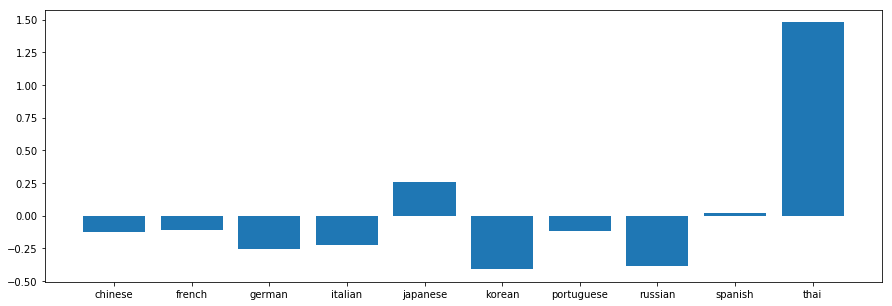

In [16]:
originalEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['originalEntropy']))
englishEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['englishEntropy']))

y_pos = np.arange(len(languages))
plt.figure(figsize=(15,5))
plt.bar(y_pos, englishEntropy.values - originalEntropy.values)
plt.xticks(y_pos, originalEntropy.index)
plt.show()

In [36]:
# z score entropy
averageEnglishEntropy = statistics.mean(df['englishEntropy'])
averageOriginalEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['originalEntropy']))
stdevEnglishEntropy = statistics.stdev(df['englishEntropy'])
stdevOriginalEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.stdev(x['originalEntropy']))
df['normalizedEnglishEntropy'] = df['englishEntropy'].apply(lambda x: (x - averageEnglishEntropy) / stdevEnglishEntropy)
df['normalizedOrginalEntropy'] = df.apply(lambda x: (x['originalEntropy'] - averageOriginalEntropy[x['originalLanguage']]) / stdevOriginalEntropy[x['originalLanguage']], axis=1)

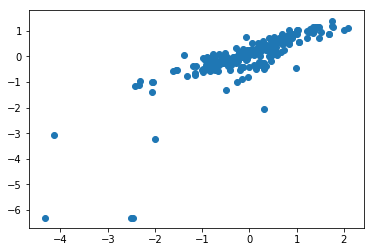

In [40]:
plt.scatter(df['normalizedOrginalEntropy'], df['normalizedEnglishEntropy'])
plt.show()

In [43]:
# z score upvotes
averageEnglishRating = statistics.mean(df['englishRating'])
averageOriginalRating = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['originalRating']))
stdevEnglishRating = statistics.stdev(df['englishRating'])
stdevOriginalRating = df.groupby('originalLanguage').apply(lambda x: statistics.stdev(x['originalRating']))
df['normalizedEnglishRating'] = df['englishRating'].apply(lambda x: (x - averageEnglishRating) / stdevEnglishRating)
df['normalizedOrginalRating'] = df.apply(lambda x: (x['originalRating'] - averageOriginalRating[x['originalLanguage']]) / stdevOriginalRating[x['originalLanguage']], axis=1)

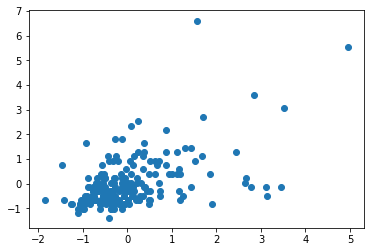

In [45]:
plt.scatter(df['normalizedOrginalRating'], df['normalizedEnglishRating'])
plt.show()

In [50]:
# log rating
zero = 0.1
df['logEnglishRating'] = df['englishRating'].apply(lambda x: np.log(x) if x != 0 else np.log(zero))
df['logOriginalRating'] = df['originalRating'].apply(lambda x: np.log(x) if x != 0 else np.log(zero))

In [52]:
# z score log rating
# z score upvotes
averageLogEnglishRating = statistics.mean(df['logEnglishRating'])
averageLogOriginalRating = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['logOriginalRating']))
stdevLogEnglishRating = statistics.stdev(df['logEnglishRating'])
stdevLogOriginalRating = df.groupby('originalLanguage').apply(lambda x: statistics.stdev(x['logOriginalRating']))
df['normalizedLogEnglishRating'] = df['logEnglishRating'].apply(lambda x: (x - averageLogEnglishRating) / stdevLogEnglishRating)
df['normalizedLogOrginalRating'] = df.apply(lambda x: (x['logOriginalRating'] - averageLogOriginalRating[x['originalLanguage']]) / stdevLogOriginalRating[x['originalLanguage']], axis=1)

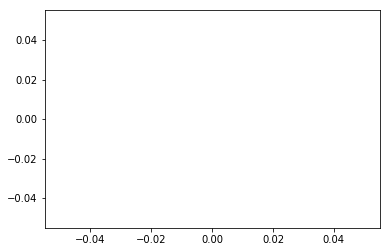

In [53]:
plt.scatter(df['normalizedLogOrginalRating'], df['normalizedLogEnglishRating'])
plt.show()

In [54]:
df.head()

,scpId,englishRating,englishDate,englishAuthor,englishAuthorKarma,originalLanguage,originalAuthor,originalDate,originalRating,originalAuthorKarma,...,originalEntropy,englishEntropy,normalizedEnglishEntropy,normalizedOrginalEntropy,normalizedEnglishRating,normalizedOrginalRating,logEnglishRating,logOriginalRating,normalizedLogEnglishRating,normalizedLogOrginalRating
0,SCP-CN-1000,12.0,29 Mar 2019 00:01,Cynthia7979,very high,chinese,Infas12,30 Oct 2018 15:25,574.0,very high,...,5.785991,6.013945,0.590733,0.806608,1.107338,1.677973,2.484907,6.352629,NaN,1.680044
1,SCP-CN-994,26.0,18 Mar 2018 07:50,W Asriel,guru,chinese,AndyBlocker,11 Mar 2018 01:28,858.0,high,...,2.700454,0.693147,-6.292733,-2.514344,3.591976,2.849803,3.258097,6.754604,NaN,2.028566
2,SCP-CN-918,4.0,04 May 2018 14:48,Idokoe,high,chinese,qjfoidnh,29 Apr 2018 15:46,49.0,very high,...,4.797172,4.774991,-1.012090,-0.257654,-0.312454,-0.488263,1.386294,3.891820,NaN,-0.453535
3,SCP-CN-844,0.0,20 Jul 2018 07:09,Cynthia7979,very high,chinese,Cynthia7979,02 Jun 2018 14:48,19.0,very high,...,5.343681,5.801107,0.315386,0.330552,-1.022351,-0.612048,-2.302585,2.944439,NaN,-1.274936
4,SCP-CN-767,11.0,10 Aug 2018 14:28,KirkeStein,high,chinese,breaddddd,15 Feb 2018 09:08,118.0,very high,...,3.184537,3.075841,-3.210265,-1.993327,0.929864,-0.203557,2.397895,4.770685,NaN,0.308461


In [57]:
stdevLogEnglishRating

nan

In [59]:
statistics.stdev(df['logEnglishRating'])

nan

In [60]:
# giving up on that...

In [73]:
df['deltaNormalizedEntropy'] = df['normalizedEnglishEntropy'] - df['normalizedOrginalEntropy']
df['deltaNormalizedRating'] = df['normalizedEnglishRating'] - df['normalizedOrginalRating']

0         chinese
1         chinese
2         chinese
3         chinese
4         chinese
5         chinese
6         chinese
7         chinese
8         chinese
9         chinese
10        chinese
11        chinese
12        chinese
13        chinese
14        chinese
15         german
16         german
17         german
18         german
19         german
20         german
21         german
22         german
23         german
24         german
25         german
26         german
27         german
28         german
29         german
          ...    
188        korean
189        korean
190        korean
191        korean
192        korean
193        korean
194        korean
195        korean
197        korean
198       russian
199       russian
200       russian
201       russian
202       russian
203       russian
204       russian
205       russian
206    portuguese
207    portuguese
208    portuguese
209    portuguese
210    portuguese
211    portuguese
212    portuguese
213    por

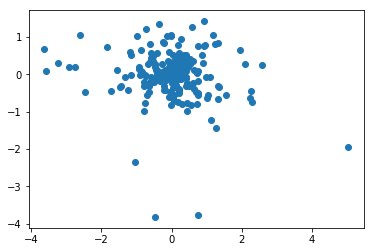

In [79]:
def ratingVsEntropy(stuff):
    print(stuff['originalLanguage'])
    plt.scatter(stuff['deltaNormalizedRating'], stuff['deltaNormalizedEntropy'])
    plt.show()
ratingVsEntropy(df)

0     chinese
1     chinese
2     chinese
3     chinese
4     chinese
5     chinese
6     chinese
7     chinese
8     chinese
9     chinese
10    chinese
11    chinese
12    chinese
13    chinese
14    chinese
Name: originalLanguage, dtype: object


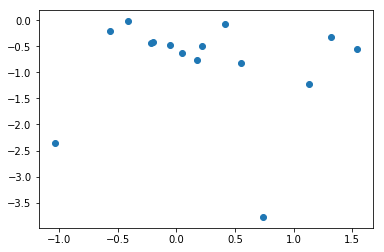

0     chinese
1     chinese
2     chinese
3     chinese
4     chinese
5     chinese
6     chinese
7     chinese
8     chinese
9     chinese
10    chinese
11    chinese
12    chinese
13    chinese
14    chinese
Name: originalLanguage, dtype: object


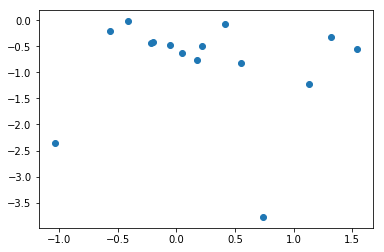

44    french
45    french
46    french
47    french
48    french
49    french
50    french
51    french
52    french
53    french
54    french
55    french
56    french
57    french
58    french
59    french
60    french
61    french
62    french
63    french
64    french
65    french
66    french
67    french
68    french
69    french
70    french
71    french
72    french
73    french
74    french
75    french
76    french
77    french
78    french
79    french
80    french
81    french
82    french
83    french
84    french
Name: originalLanguage, dtype: object


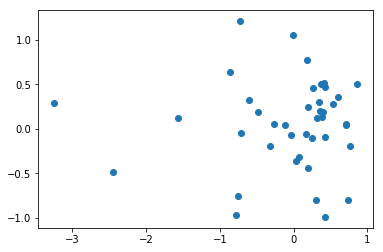

15    german
16    german
17    german
18    german
19    german
20    german
21    german
22    german
23    german
24    german
25    german
26    german
27    german
28    german
29    german
30    german
31    german
32    german
33    german
34    german
35    german
36    german
37    german
38    german
39    german
40    german
41    german
42    german
43    german
Name: originalLanguage, dtype: object


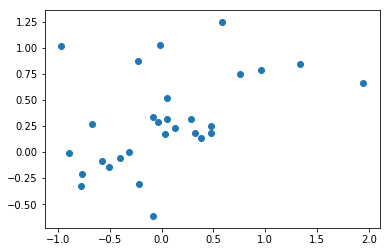

167    italian
168    italian
169    italian
170    italian
171    italian
172    italian
173    italian
174    italian
175    italian
176    italian
177    italian
178    italian
179    italian
Name: originalLanguage, dtype: object


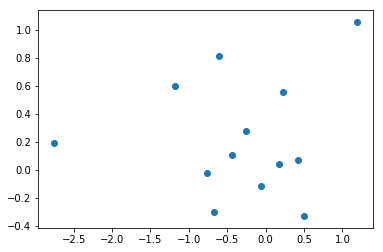

91     japanese
92     japanese
93     japanese
94     japanese
95     japanese
96     japanese
97     japanese
98     japanese
99     japanese
100    japanese
101    japanese
102    japanese
103    japanese
104    japanese
105    japanese
106    japanese
107    japanese
108    japanese
109    japanese
110    japanese
111    japanese
112    japanese
113    japanese
114    japanese
115    japanese
116    japanese
117    japanese
118    japanese
119    japanese
Name: originalLanguage, dtype: object


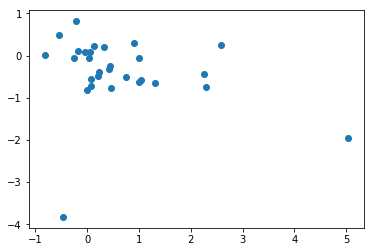

181    korean
182    korean
183    korean
184    korean
185    korean
186    korean
187    korean
188    korean
189    korean
190    korean
191    korean
192    korean
193    korean
194    korean
195    korean
197    korean
Name: originalLanguage, dtype: object


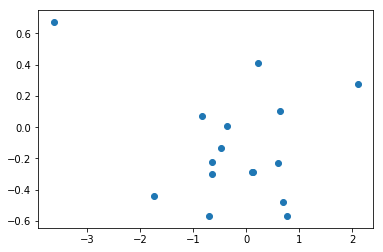

206    portuguese
207    portuguese
208    portuguese
209    portuguese
210    portuguese
211    portuguese
212    portuguese
213    portuguese
214    portuguese
215    portuguese
216    portuguese
217    portuguese
218    portuguese
Name: originalLanguage, dtype: object


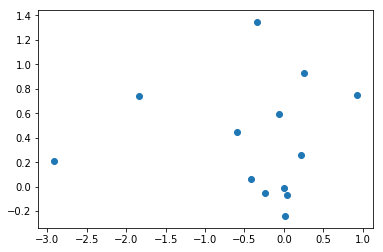

198    russian
199    russian
200    russian
201    russian
202    russian
203    russian
204    russian
205    russian
Name: originalLanguage, dtype: object


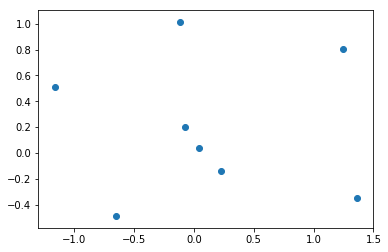

121    spanish
122    spanish
123    spanish
124    spanish
125    spanish
126    spanish
127    spanish
128    spanish
129    spanish
130    spanish
131    spanish
132    spanish
133    spanish
134    spanish
135    spanish
136    spanish
137    spanish
138    spanish
139    spanish
140    spanish
141    spanish
142    spanish
143    spanish
144    spanish
145    spanish
146    spanish
147    spanish
148    spanish
149    spanish
150    spanish
151    spanish
152    spanish
153    spanish
154    spanish
155    spanish
156    spanish
157    spanish
158    spanish
159    spanish
160    spanish
161    spanish
162    spanish
163    spanish
164    spanish
165    spanish
Name: originalLanguage, dtype: object


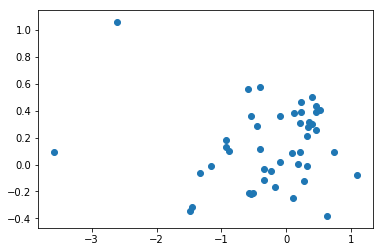

86    thai
87    thai
88    thai
89    thai
Name: originalLanguage, dtype: object


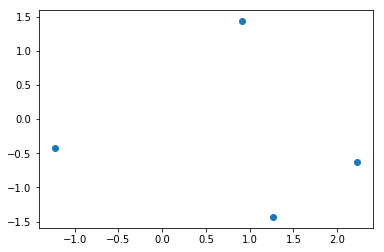

""


In [80]:
df.groupby('originalLanguage').apply(ratingVsEntropy)